In the Orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results

This workflow is well-suited for complex tasks where you can't predict the subtasks needed(in coding, for ex, the no. of files that need to be changed and the nature of the change in each file likely depend on the task).

Whereas it's topographically similar, the key diff from parallelization is its flexibility--subtasks aren't pre-defined, but determined by the orchestrator based on the specific input

In [4]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

result = llm.invoke("What is the capital of France?")
result.content

'The capital of France is Paris.'

In [1]:
from typing import Annotated, List
import operator
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

In [ ]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(description="name for the section of the report")
    description: str = Field(description="brief overview of the main topics & concepts of the section")

In [5]:
class Sections(BaseModel):
    sections: List[Section] = Field(description="sections of the report")

# LLM should return based on the Schema
# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

## creating the workers Dynamically in Langgraph


Because orchestrator-worker workflows are common, LangGraph has the SEND API to support this. It lets you dynamically create worker nodes & and send each one a specific input. Each worker has it's own state, & all worker outputs r written to the shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output & allows it to synthesize them into a final output.

As you can see below, we iterate over a list of sections & Send each to a worker node.

In [ ]:
from langgraph.types import Send

# Graph State:
class GraphState(TypedDict):
    topic: str # Report topic
    sections: List[Section] # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ] # All workers write to this key in parallel
    final_report: str # Final report to combine all sections



In [13]:
# when ever we create any worker dynamically, each worker has it's
# own state, if it has it's own state, then we need to define another state like below:

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add] # adding to this list that every section that has got generated.
    

In [10]:
# Orchestrator will create a report plan & then we need to orchestrate
# it means, provide the work to the workers.
# So first task of the orchestrator is to create the report(outline structure of the report).

In [18]:
# Nodes
def orchestrator(state: GraphState):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),

        ]
    )

    print("report sections: ", report_sections)

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""
     
    # Generate section
    section_content = llm.invoke(
        [
            SystemMessage(content="Write a report section following the provided name & description. Include no preamble for each section."),
            HumanMessage(content=f"Here is the section name: {state['section']['name']} & description: {state['section']['description']}"),
        ]
    )  

    # Format the section with title and content
    formatted_section = f"## {state['section']['name']}\n\n{section_content.content}"
    
    # write the formatted section to completed sections
    return {"completed_sections": [formatted_section]}


# How do we make sure that worker is basically created and parallely this 
# above llm_call is happening for every worker.
# for this we will use SEND API


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: GraphState):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via SEND() api
    return [Send("llm_call", {"section": s}) for s in state["sections"]]



def synthesizer(state: GraphState):
    """Synthesize full report from completed sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

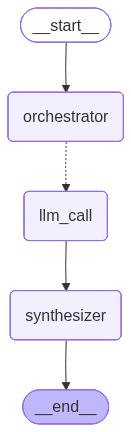

In [19]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

orchestrator_worker_builder = StateGraph(GraphState)

# Add Nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", 
    assign_workers,
    ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# compile the graph
orchestrator_worker = orchestrator_worker_builder.compile()

#Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


In [20]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAG"})

from IPython.display import Markdown
Markdown(state["final_report"])

report sections:  sections=[Section(nae='Introduction to Agentic AI RAG', description='This section will provide an overview of Agentic AI and the concept of Retrieval-Augmented Generation (RAG). It will define key terms and explain the significance of combining these technologies.'), Section(nae='Understanding Agentic AI', description='This section will delve into what Agentic AI is, its characteristics, and how it differs from traditional AI systems. It will explore the implications of AI systems that can act autonomously.'), Section(nae='Overview of Retrieval-Augmented Generation (RAG)', description='This section will explain the RAG framework, detailing how it enhances AI capabilities by integrating retrieval mechanisms with generative models. It will discuss the architecture and functioning of RAG.'), Section(nae='Applications of Agentic AI RAG', description='This section will highlight various applications of Agentic AI RAG across different industries, such as healthcare, finance

TypeError: 'Section' object is not subscriptable

In [21]:
# Test the fixed orchestrator worker
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAG"})

# Check if final_report exists in the state
print("State keys:", state.keys())
print("\n" + "="*50 + "\n")

# Display the final report
from IPython.display import Markdown
Markdown(state["final_report"])


report sections:  sections=[Section(nae='Introduction to Agentic AI RAG', description='This section will provide an overview of Agentic AI and the concept of Retrieval-Augmented Generation (RAG). It will define key terms and explain the significance of combining these technologies.'), Section(nae='Understanding Agentic AI', description='This section will delve into what Agentic AI is, its characteristics, and how it differs from traditional AI systems. It will explore the implications of AI systems that can act autonomously.'), Section(nae='Overview of Retrieval-Augmented Generation (RAG)', description='This section will explain the RAG framework, detailing how it integrates retrieval mechanisms with generative models to enhance the quality and relevance of AI-generated content.'), Section(nae='Applications of Agentic AI RAG', description='This section will discuss various applications of Agentic AI RAG across different industries, including healthcare, finance, and customer service, h

TypeError: 'Section' object is not subscriptable